In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

import sklearn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import class_weight

import IvysaurusModel_VGG_BN
import FileHelper

In [2]:
dimensions = 24
nClasses = 5

nTrackVars = 10 # nTrackChildren, nShowerChildren, nGrandChildren, nChildHits, childEnergy, childTrackScore, trackLength, trackWobble, trackScore, momComparison
nShowerVars = 3 # displacement, dca, trackStubLength

In [3]:
startGridU_train = np.empty((0, dimensions, dimensions, 1))
startGridV_train = np.empty((0, dimensions, dimensions, 1))
startGridW_train = np.empty((0, dimensions, dimensions, 1))

endGridU_train = np.empty((0, dimensions, dimensions, 1))
endGridV_train = np.empty((0, dimensions, dimensions, 1))
endGridW_train = np.empty((0, dimensions, dimensions, 1))

trackVars_train = np.empty((0, nTrackVars))
showerVars_train = np.empty((0, nShowerVars))

y_train = np.empty((0, nClasses))

startGridU_test = np.empty((0, dimensions, dimensions, 1))
startGridV_test = np.empty((0, dimensions, dimensions, 1))
startGridW_test = np.empty((0, dimensions, dimensions, 1))

endGridU_test = np.empty((0, dimensions, dimensions, 1))
endGridV_test = np.empty((0, dimensions, dimensions, 1))
endGridW_test = np.empty((0, dimensions, dimensions, 1))

trackVars_test = np.empty((0, nTrackVars))
showerVars_test = np.empty((0, nShowerVars))

y_test = np.empty((0, nClasses))

trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/Ivysaurus/files/*/ivysaurus_*.npz')
print(trainFileNames)

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    startGridU_train = np.concatenate((startGridU_train, data['startGridU_test']), axis=0)
    startGridV_train = np.concatenate((startGridV_train, data['startGridV_test']), axis=0)
    startGridW_train = np.concatenate((startGridW_train, data['startGridW_test']), axis=0)
    
    startGridU_test = np.concatenate((startGridU_test, data['startGridU_train']), axis=0)
    startGridV_test = np.concatenate((startGridV_test, data['startGridV_train']), axis=0) 
    startGridW_test = np.concatenate((startGridW_test, data['startGridW_train']), axis=0)
    
    endGridU_train = np.concatenate((endGridU_train, data['endGridU_test']), axis=0)
    endGridV_train = np.concatenate((endGridV_train, data['endGridV_test']), axis=0)
    endGridW_train = np.concatenate((endGridW_train, data['endGridW_test']), axis=0)
    
    endGridU_test = np.concatenate((endGridU_test, data['endGridU_train']), axis=0)
    endGridV_test = np.concatenate((endGridV_test, data['endGridV_train']), axis=0)
    endGridW_test = np.concatenate((endGridW_test, data['endGridW_train']), axis=0)
    
    trackVars_train = np.concatenate((trackVars_train, data['trackVars_test']), axis=0)
    trackVars_test = np.concatenate((trackVars_test, data['trackVars_train']), axis=0)

    showerVars_train = np.concatenate((showerVars_train, data['showerVars_test']), axis=0)
    showerVars_test = np.concatenate((showerVars_test, data['showerVars_train']), axis=0)
    
    y_train = np.concatenate((y_train, data['y_test']), axis=0)
    y_test = np.concatenate((y_test, data['y_train']), axis=0)

['/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_0.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_1.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_3.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_2.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_5.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nutau/ivysaurus_nutau_4.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_2.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_3.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_1.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_0.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_4.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nu/ivysaurus_nu_5.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nue/ivysaurus_nue_5.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/nue/ivysaurus_nue_4.npz', '/Users

In [4]:
print('startGridU_train: ', startGridU_train.shape)
print('startGridV_train: ', startGridV_train.shape)
print('startGridW_train: ', startGridW_train.shape)
print('startGridU_test: ', startGridU_test.shape)
print('startGridV_test: ', startGridV_test.shape)
print('startGridW_test: ', startGridW_test.shape)
   
print('endGridU_train: ', endGridU_train.shape)    
print('endGridV_train: ', endGridV_train.shape)
print('endGridW_train: ', endGridW_train.shape)
print('endGridU_test: ', endGridU_test.shape)     
print('endGridV_test: ', endGridV_test.shape)     
print('endGridW_test: ', endGridW_test.shape) 
    
print('trackVars_train: ', trackVars_train.shape)    
print('trackVars_test: ', trackVars_test.shape)  

print('y_train: ', y_train.shape)
print('y_test', y_test.shape)

startGridU_train:  (2086751, 24, 24, 1)
startGridV_train:  (2086751, 24, 24, 1)
startGridW_train:  (2086751, 24, 24, 1)
startGridU_test:  (231852, 24, 24, 1)
startGridV_test:  (231852, 24, 24, 1)
startGridW_test:  (231852, 24, 24, 1)
endGridU_train:  (2086751, 24, 24, 1)
endGridV_train:  (2086751, 24, 24, 1)
endGridW_train:  (2086751, 24, 24, 1)
endGridU_test:  (231852, 24, 24, 1)
endGridV_test:  (231852, 24, 24, 1)
endGridW_test:  (231852, 24, 24, 1)
trackVars_train:  (2086751, 10)
trackVars_test:  (231852, 10)
y_train:  (2086751, 5)
y_test (231852, 5)


In [5]:
# load model

ivysaurusCNN = keras.models.load_model('/Users/isobel/Desktop/DUNE/Ivysaurus/files/my_model_VGG_BN')

# Check its architecture
#ivysaurusCNN.summary()

print("Loaded model from disk")


Loaded model from disk


In [6]:
# Use the network to predict the category of the test sample

y_pred = ivysaurusCNN.predict([startGridU_test, endGridU_test, startGridV_test, endGridV_test, startGridW_test, endGridW_test, trackVars_test, showerVars_test])


7246/7246 [==============================] - 124s 17ms/step


[[8.9999312e-01 1.0383321e-02 8.9616336e-02 2.6025079e-06 4.7462022e-06]]


trueSums:  [26011 64831 55587 23761 61662]
predSums:  [28524 61721 56298 27154 58155]
[[22042   104  2909   309   647]
 [  448 59609  4446   134   194]
 [ 4714  1750 47688   597   838]
 [  289    70   375 18639  4388]
 [ 1031   188   880  7475 52088]]


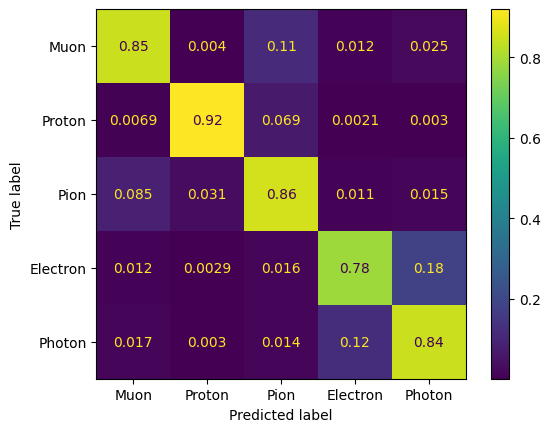

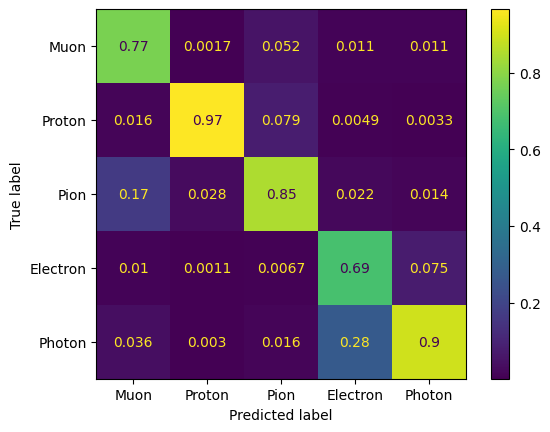

In [7]:
# Let's look at the confusion matrix

confMatrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

trueSums = np.sum(confMatrix, axis=1)
predSums = np.sum(confMatrix, axis=0)

print('trueSums: ', trueSums)
print('predSums: ', predSums)

trueNormalised = np.zeros(shape=(nClasses, nClasses))
predNormalised = np.zeros(shape=(nClasses, nClasses))

for trueIndex in range(nClasses) : 
    for predIndex in range(nClasses) :
        nEntries = confMatrix[trueIndex][predIndex]
        if trueSums[trueIndex] > 0 :
            trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
        if predSums[predIndex] > 0 :
            predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon"])
displayTrueNorm.plot()

displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon"])
displayPredNorm.plot()

print(confMatrix)

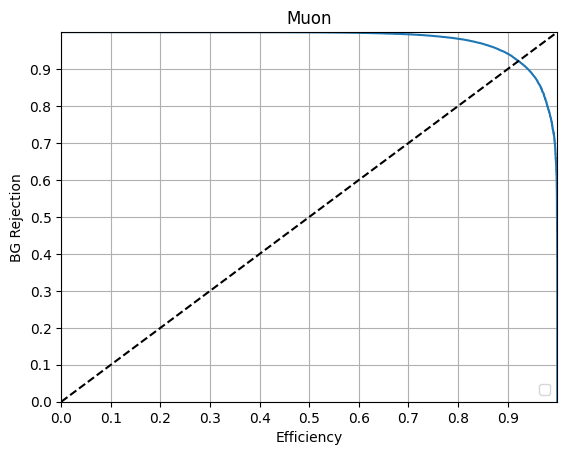

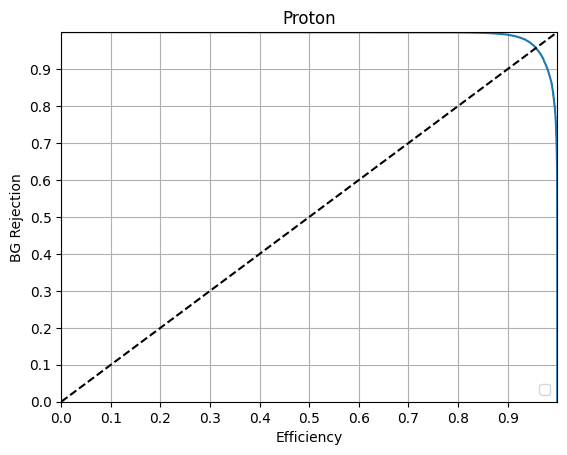

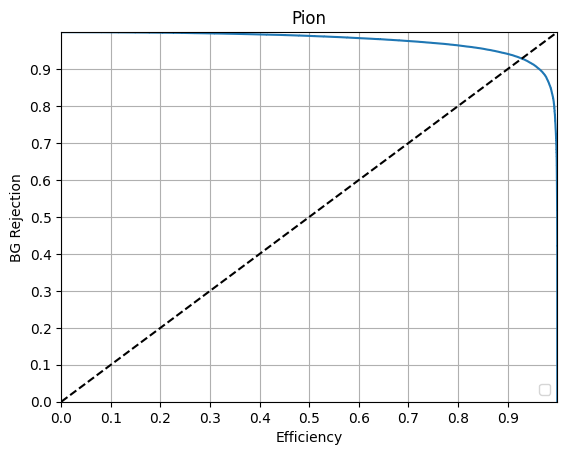

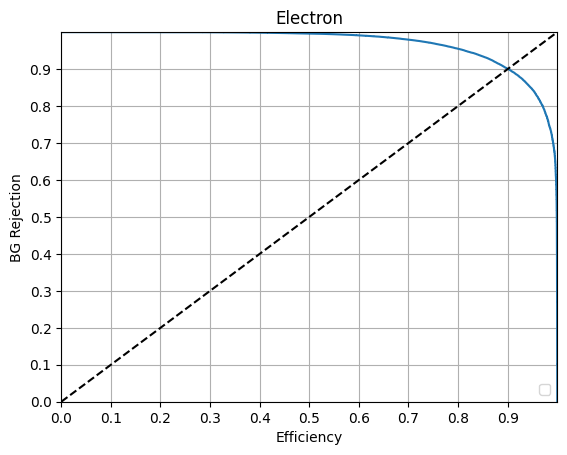

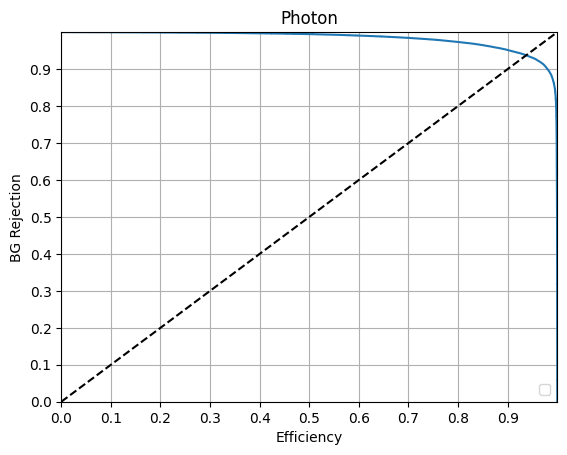

In [10]:
# Compute ROC curve and ROC area for each class

falsePositive = dict()
bkgRejection = dict()
truePositive = dict()
roc = dict()

for i in range(nClasses):
    falsePositive[i], truePositive[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    bkgRejection[i] = 1 - falsePositive[i]
    roc[i] = sklearn.metrics.auc(falsePositive[i], bkgRejection[i])

# Plot of a ROC curve for a specific class

rocCurveTitles = ["Muon", "Proton", "Pion", "Electron", "Photon", "Other"]

for i in range(nClasses):
    plt.figure()
    plt.plot(truePositive[i], bkgRejection[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.arange(0, 1, 0.1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.xlabel('Efficiency')
    plt.ylabel('BG Rejection')
    plt.title(rocCurveTitles[i])
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

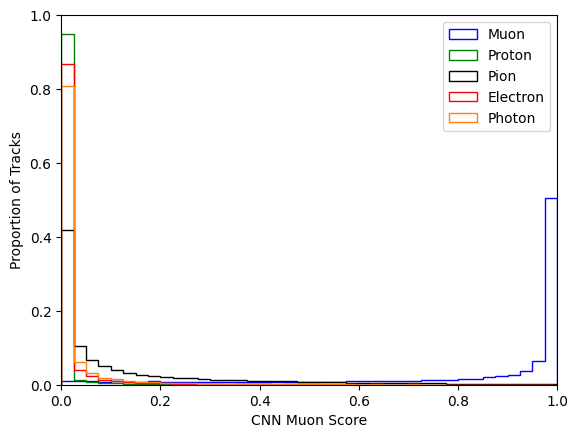

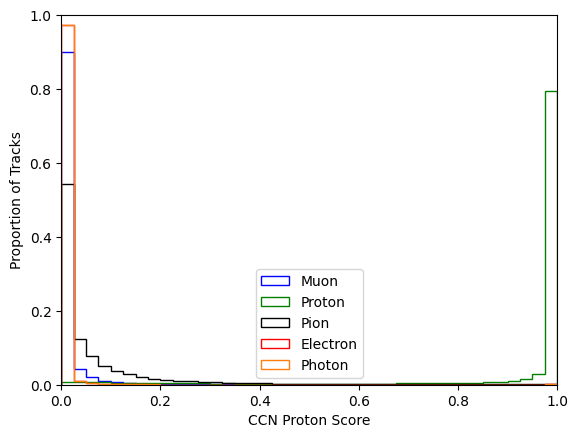

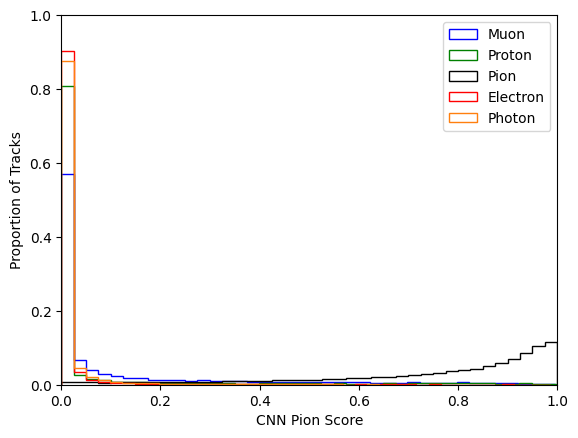

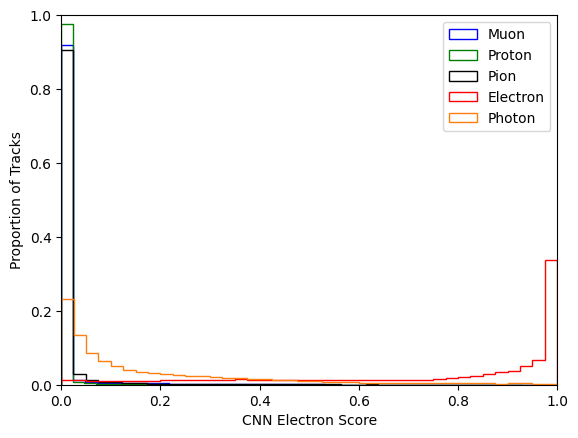

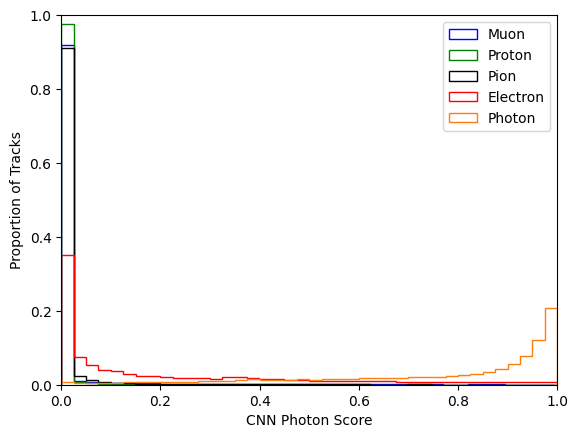

In [11]:
particleColors = ('b', 'g', 'k', 'r', 'tab:orange', 'tab:gray')
histTitles = ('CNN Muon Score', 'CCN Proton Score', 'CNN Pion Score', 'CNN Electron Score', 'CNN Photon Score', 'CNN Other Score')

for i in range(nClasses) :
    for j in range(nClasses) :
        nTrueParticles = trueSums[j]
        weights = np.full(nTrueParticles, 1.0/nTrueParticles)
        plt.hist(y_pred[y_test[:,j] == 1][:,i], bins=40, weights=weights, color=particleColors[j], histtype='step')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel(histTitles[i])
        plt.ylabel('Proportion of Tracks')
        plt.legend(['Muon', 'Proton', 'Pion', 'Electron', 'Photon', 'Other'])
    plt.show()

In [15]:
incorrectIndicies = []

targetTruth = 0 
targetPred = 4

for i in range (y_pred.shape[0]) :
    prediction = np.argmax(y_pred[i])
    truth = np.argmax(y_test[i])
    
    if ((prediction == targetPred) & (truth == targetTruth)):
        incorrectIndicies.append([i, prediction, truth])
    
print(incorrectIndicies)         

[[528, 4, 0], [616, 4, 0], [1012, 4, 0], [1268, 4, 0], [1300, 4, 0], [1321, 4, 0], [1348, 4, 0], [1850, 4, 0], [2115, 4, 0], [2528, 4, 0], [2952, 4, 0], [3071, 4, 0], [3412, 4, 0], [3696, 4, 0], [4005, 4, 0], [4272, 4, 0], [4687, 4, 0], [5167, 4, 0], [5276, 4, 0], [5298, 4, 0], [5456, 4, 0], [5563, 4, 0], [7063, 4, 0], [7139, 4, 0], [7208, 4, 0], [8538, 4, 0], [8611, 4, 0], [8689, 4, 0], [9443, 4, 0], [10337, 4, 0], [10451, 4, 0], [10579, 4, 0], [10588, 4, 0], [10611, 4, 0], [10649, 4, 0], [10833, 4, 0], [11607, 4, 0], [12103, 4, 0], [12320, 4, 0], [12476, 4, 0], [12509, 4, 0], [13125, 4, 0], [13361, 4, 0], [13517, 4, 0], [14218, 4, 0], [14485, 4, 0], [15542, 4, 0], [15734, 4, 0], [16286, 4, 0], [16357, 4, 0], [17088, 4, 0], [17466, 4, 0], [17609, 4, 0], [18184, 4, 0], [18685, 4, 0], [18699, 4, 0], [18838, 4, 0], [19169, 4, 0], [19188, 4, 0], [19370, 4, 0], [19383, 4, 0], [19874, 4, 0], [19882, 4, 0], [20009, 4, 0], [20020, 4, 0], [20579, 4, 0], [20595, 4, 0], [21248, 4, 0], [21400, 4,

[6.13069795e-02 1.10626977e-03 1.03850114e-04 2.03782499e-01
 7.33700395e-01 1.41895965e-11]


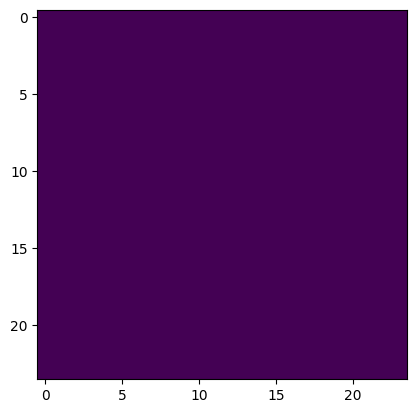

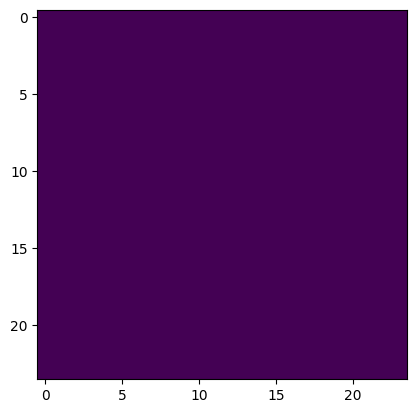

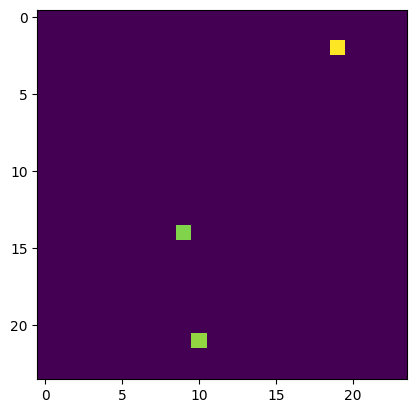

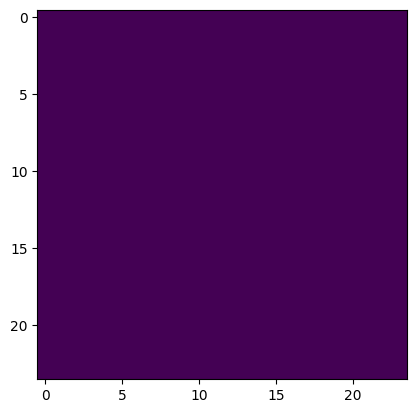

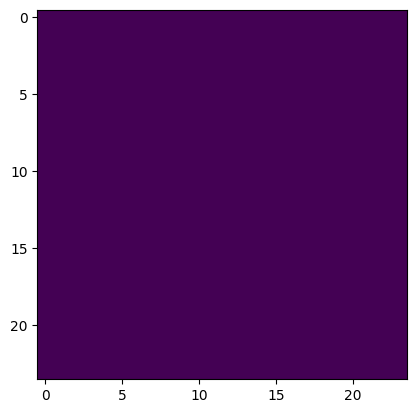

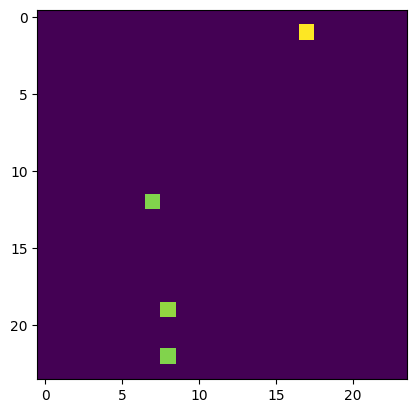

In [16]:
indexToView = 528

print(y_pred[indexToView])

fig_startU, ax_startU = plt.subplots(1,1)
ax_startU.imshow(startGridU_test[indexToView])

fig_startV, ax_startV = plt.subplots(1,1)
ax_startV.imshow(startGridV_test[indexToView])

fig_startW, ax_startW = plt.subplots(1,1)
ax_startW.imshow(startGridW_test[indexToView])
    
fig_endU, ax_endU = plt.subplots(1,1)
ax_endU.imshow(endGridU_test[indexToView])

fig_enV, ax_endV = plt.subplots(1,1)
ax_endV.imshow(endGridV_test[indexToView])

fig_endW, ax_endW = plt.subplots(1,1)
ax_endW.imshow(endGridW_test[indexToView])